## Inverse Problem Data Generation

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# set seed to ensure reproducibility
np.random.seed(42)

n = 100
x = np.sort(np.random.uniform(0, 1, size=(n,)))

#### Generate Target Data (Considering Forward Problem)

$$
t = x_n + 0.3 sin(2\pi x_n) + e \\
$$
$$
e \sim \text{Uniform}(-0.1, 0.1)
$$

In [20]:
t = x + 0.3 * np.sin(2 * np.pi * x) + np.random.uniform(-0.1, 0.1, size=(n,))

#### Plot Forward Problem Data

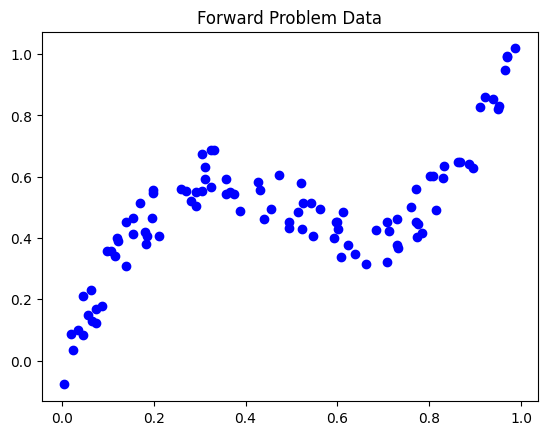

In [23]:
plt.plot(x, t, 'bo')
plt.title('Forward Problem Data')
plt.show()

#### Plot Inverse Problem Data

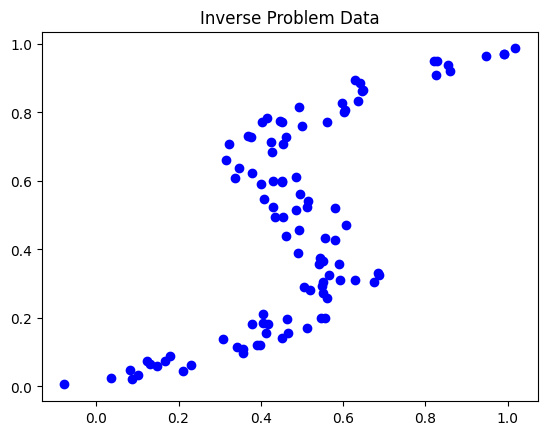

In [25]:
# on swapping t and x
plt.plot(t, x, 'bo')
plt.title('Inverse Problem Data')
plt.show()

## Fit using usual method from Supervised Learning